# Maven Power Outage Challenge - Exploratory Data Analysis

[insert description of challenge, data and objectives]

## Step 0. Understanding the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import openpyxl

In [211]:
# Define the sheet names in a list so that we can easily iterate through the excel sheets (tabs). 
# Each sheet contains power outage event data for a year between 2002 and 2023

sheet_names = [str(n) for n in range(2002, 2024, 1)]

In [212]:
# Creating a dictionary of pandas dataframes, one dataframe per excel sheet. 
# this will allow us to tailor our data cleaning to the individual sheet since the format of the sheet changes over the years.

DF_dict = {}

for sheet in sheet_names:
    if sheet in ["2002", "2008"]:
        header_value = 2
    else:
        header_value = 1
    
    DF_dict["{0}".format(sheet)] = pd.read_excel('DOE_Electric_Disturbance_Events.xlsx', 
                                                 engine='openpyxl', 
                                                 header=header_value, 
                                                 sheet_name=sheet)

In [213]:
# We will not use this right now, but the dictionary starting_shapes will help us to 
# understand the data better as we are cleaning

starting_shapes = {}
for sheet in sheet_names:
    starting_shapes[sheet] = DF_dict[str(sheet)].shape


In [214]:
# Now lets check out one of the dataframes to see if we get the data we expect:
DF_dict["2008"].head()

,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Date/Time,NaN,NaN,NaN,NaN
1,January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-04 00:00:00,WECC,4:00 a.m.,Northern California,Winter Storm,500,2606931,5:00 p.m. January 14,NaN,NaN,NaN,NaN
3,2008-01-04 00:00:00,WECC,7:47 a.m.,Sacramento County,Severe Storm,300,150000,4:30 p.m. January 04,NaN,NaN,NaN,NaN
4,2008-01-29 00:00:00,WECC,5:00 a.m.,"San Francisco Bay Area, California",Exciter Faulted,NaN,-,12:17 p.m. January 29,NaN,NaN,NaN,NaN


The data above is what I expect, however it is very messy! Generally I will need to:
- Make sure columns in each dataframe match (i.e. contain the same feature information)
- Check data within the columns to ensure quality
- Concatenate thesource dataframes to create a single datasource

In [215]:
# Now lets explore how the column names vary between dataframes:

column_title_dictionary = {"{0}".format(sheet):DF_dict["{0}".format(sheet)].columns.tolist() for sheet in sheet_names}
column_title_df = pd.DataFrame.from_dict(column_title_dictionary, orient='index') #use the orient argument to make the keys of the dictionary equivalent to the index values of the dataframe
column_title_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2002,Date,NERC Region,Time,Area,Type of Disturbance,Loss (megawatts),Number of Customers Affected,Restoration Time,None,None,None,None,None,None,None,None,None,None,None
2003,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2004,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2005,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2006,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2007,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1[1],Restoration,None,None,None,None,None,None,None,None,None,None,None
2008,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,None,None,None,None,None,None,None
2009,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2010,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2011,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18


### The target column names

From the dataframe above, we can see that the columns titles make a significant change two times between 2002 - 2023. 

I will approach the data cleaning process slightly differently for each of the three periods: 2002-2010, 2011-2014, 2015-2023

Here are the column names that I will have in the cleaned and concatenated dataframe:
1. "datetime_event_began", 
2. "NERC_region", 
3. "area_affected", 
4. "event_type", 
5. "demand_loss_(MW)", 
6. "number_of_customers_affected", 
7. "datetime_of_restoration"

In [216]:
post_cleaning_column_titles = ["datetime_event_began", 
                               "NERC_region", 
                               "area_affected", 
                               "event_type", 
                               "demand_loss_(MW)", 
                               "number_of_customers_affected", 
                               "datetime_of_restoration"]

## Step 1. Cleaning the data

### How will I manipulate the dataframes so that I have seven consistent features accross all dataframes?
From 2002 to 2010:
- reorder columns so that columns 1 and 2 switch places(i.e. "Time" comes before NERC Region)
- concatenate columns 0 and 1. This value will override existing column 0 and should leave you with one column that containes datetime_event_begins
- rename columns so that they match the names from post_cleaning_column_titles

From 2011 to 2014:
- 

From 2015 to 2023:

### Cleaning dataframes from the years 2002 - 2010:

In [217]:
# for the dataframes containing data from 2002 to 2010, I am starting by reordering columns so that columns 1 and 2 switch places(i.e. "Time" comes before NERC Region)
for sheet in list(range(2002,2011,1)):
    temp_cols_list = DF_dict["{0}".format(sheet)].columns.tolist()
    save_col1 = temp_cols_list[1] 
    temp_cols_list[1] = temp_cols_list[2]
    temp_cols_list[2] = save_col1
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][temp_cols_list]

In [218]:
# Lets create a function that takes a dataframe, iterates through the rows, and checkes that the "Date" column to a 
# datetime datatype. otherwise it drops the row because this indicates the row is an unexpected format and in this instance 
# most likely a human readable marker.

from datetime import datetime

def drop_non_datetime_values(dataframe_name, column_name):
    for ind, row in dataframe_name.iterrows():
        if type(dataframe_name[column_name][ind]) == datetime:
            pass
        else:
            dataframe_name.drop(axis=0, index=ind, inplace=True)
    return dataframe_name
           

In [219]:
# Removing rows from the dataframe that are redundant or that repeat the column names.
for sheet in list(range(2002,2011,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date")

In [220]:
# We have discovered some "Time" value that can not be changed to a time datatype due to how 
# they have been entered into the database. I will adjust these one-by-one to preserve as much information as possible:

DF_dict["2002"].loc[3, "Time"] = "20:00:00"  # Original value = "Evening"
DF_dict["2003"].loc[56, "Time"] = "15:00:00" # Original value = "Approximately 3:00 p.m."
DF_dict["2003"].loc[78, "Time"] = "12:00:00" # Original value = "12:00 noon"
DF_dict["2004"].loc[3, "Time"] = "00:00:00"  # Original value = "Midnight"
DF_dict["2004"].loc[81, "Time"] = "09:52:00" # Original value = "9: 52 a.m."
DF_dict["2005"].loc[13, "Time"] = "17:28:00" # Original value = "5:78 p.m."
DF_dict["2005"].loc[21, "Time"] = "00:00:00" # Original value = "Midnight"
DF_dict["2006"].loc[12, "Time"] = "00:00:00" # Original value = "Ongoing"

# This is the code I used to find the index value of the problematic time data:
# DataFrame_dict["sheet2006"][DataFrame_dict["sheet2006"]["Time"] == "Ongoing"].index.values[0]

In [221]:
# Now that the date and time columns are in a format that can be recognised by pd.to_datetime, 
# lets concatenate these two columns

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)]['Date'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]['Time'].astype(str))

In [222]:
# Now that the time data is included in the first column of our dataframe we can drop the "Time" column 
# from the dataframes containing data for years 2002 - 2010

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop("Time", axis=1)

In [223]:
DF_dict["2002"].head()

,Date,NERC Region,Area,Type of Disturbance,Loss (megawatts),Number of Customers Affected,Restoration Time
1,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
3,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
4,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
6,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
8,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00


In [224]:
# Now that dataframes for 2002 - 2010 are fairly clean let us standardise the column names so we can concatenate the dataframes:

for sheet in list(range(2002,2011,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)


In [225]:
DF_dict["2002"].head() #Note, there is still some cleaning to do but we have the dataframe in the general format we want

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
1,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
3,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
4,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
6,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
8,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00


In [226]:
# Now we will move on to the dataframes that contain data for years 2011 - 2014. Lets look at the dataframe:
DF_dict["2012"].head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,January,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-04 00:00:00,12:14:00,2012-01-04 00:00:00,12:14:00,"Tacoma, Washington",WECC,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
2,2012-01-05 00:00:00,10:35:00,2012-01-05 00:00:00,12:25:00,"CSWS/AEP West territory, Oklahoma",SPP,Sabotage,0,0,NaN,NaN,NaN
3,2012-01-05 00:00:00,10:28:00,2012-01-05 00:00:00,12:25:00,"Creek County, Oklahoma",SPP,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
4,2012-01-09 00:00:00,14:30:00,2012-01-09 00:00:00,15:30:00,"Watertown, Connecticut",NPCC,Vandalism,NaN,NaN,NaN,NaN,NaN


In [227]:
# Step one, drop values from "Date Event Began" that are not datetime datatypes:
for sheet in list(range(2011,2015,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date Event Began")

In [228]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

def date_only(start_year, stop_year, name_of_date_col):
    for sheet in list(range(start_year, stop_year+1, 1)):
        DF_dict["{0}".format(sheet)][name_of_date_col] = pd.to_datetime(DF_dict["{0}".format(sheet)][name_of_date_col]).dt.date
        

In [229]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

date_only(2011,2014,'Date Event Began')

In [230]:
DF_dict["2012"].head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11
1,2012-01-04,12:14:00,2012-01-04 00:00:00,12:14:00,"Tacoma, Washington",WECC,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
2,2012-01-05,10:35:00,2012-01-05 00:00:00,12:25:00,"CSWS/AEP West territory, Oklahoma",SPP,Sabotage,0,0,NaN,NaN,NaN
3,2012-01-05,10:28:00,2012-01-05 00:00:00,12:25:00,"Creek County, Oklahoma",SPP,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
4,2012-01-09,14:30:00,2012-01-09 00:00:00,15:30:00,"Watertown, Connecticut",NPCC,Vandalism,NaN,NaN,NaN,NaN,NaN
5,2012-01-09,13:36:00,2012-01-11 00:00:00,01:05:00,Louisiana,SERC,Load Shed,150,1,NaN,NaN,NaN


In [231]:
# Merge date and time information

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [232]:
#Let us make sure the third column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

for sheet in list(range(2011,2015,1)):
    for ind, row in DF_dict["{0}".format(sheet)].iterrows():
        if type(DF_dict["{0}".format(sheet)]['Date of Restoration'][ind]) != datetime:
            DF_dict["{0}".format(sheet)]['Date of Restoration'][ind] = datetime.now().date()
            #DataFrame_dict["sheet{0}".format(sheet)]['Time of Restoration'][ind] = datetime.now().time()
            
        if type(DF_dict["{0}".format(sheet)]['Time of Restoration'][ind]) == str:
            DF_dict["{0}".format(sheet)]['Time of Restoration'][ind] = "00:00:00"
    
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration']).dt.date
        

c:\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\python36-32\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [233]:
for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [234]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [235]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [236]:
for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [237]:
DF_dict["2014"].head()

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
1,2014-01-06 19:50:00,RFC,District of Columbia,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:44:00
2,2014-01-06 19:50:00,RFC,Unknown,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:44:00
3,2014-01-06 19:52:00,RFC,Delaware,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:45:00
4,2014-01-06 20:45:00,RFC,Unknown,Public Appeal due to Severe Weather - Cold,Unknown,Unknown,2014-01-07 21:00:00
5,2014-01-06 19:50:00,RFC,Pennsylvania,Voltage Reduction due to Severe Weather - Cold,200,62000,2014-01-06 20:49:00


In [238]:
# Now we will move on to the dataframes that contain data for years 2015 - 2023. Lets look at the dataframe:

In [239]:
DF_dict["2018"].head()

,Month,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected
0,January,01/01/2018,18:21:00,01/02/2018,18:11:00,Tennessee:,SERC,Public appeal to reduce the use of electricity...,Severe Weather,Unknown,Unknown
1,January,01/01/2018,17:43:00,Unknown,Unknown,Texas:,TRE,Public appeal to reduce the use of electricity...,Severe Weather,Unknown,Unknown
2,January,01/01/2018,21:37:00,01/02/2018,10:30:00,Tennessee:,SERC,Public appeal to reduce the use of electricity...,System Operations,Unknown,Unknown
3,January,01/02/2018,10:00:00,02/12/2018,08:00:00,New York: Niagara County;,NPCC,Fuel supply emergencies that could impact elec...,Fuel Supply Deficiency,675,Unknown
4,January,01/02/2018,07:30:00,Unknown,Unknown,South Carolina:,SERC,Public appeal to reduce the use of electricity...,Severe Weather,0,717000


In [240]:
# Drop month column because it is redundant and also drop alert criteria column, we will not be analysing this column this time. 

for sheet in list(range(2015,2024,1)):
    column_titles = DF_dict["{0}".format(sheet)].columns.tolist()
    if "Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Month"], axis=1)
    if "Event Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Month"], axis=1)
    if "Event Year" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Year"], axis=1)
    if "Alert Criteria" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Alert Criteria"], axis=1)

In [241]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

date_only(2015, 2023, "Date Event Began")

In [242]:
# We have data issues in sheets 2015, 2016, 2017. 
# The issue is that these sheets have many rows of NaNs at the very bottom of the spreadsheet that we need to remove

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

2015 48
2016 50
2017 41
2018 0
2019 0
2020 0
2021 0
2022 0
2023 0


In [243]:
# instead of dropping rows that have NaN, how about we keep rows that are not NaN:

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date Event Began'].notna()]

In [244]:
# The code above has resolved the issues of the NaNs at the very bottom of some of the spreadsheets

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

2015 0
2016 0
2017 0
2018 0
2019 0
2020 0
2021 0
2022 0
2023 0


In [245]:
# keep rows that are not "Unknown" 
# (There are a significant number of unknown values that are preventing us from processing the datetime columns properly)

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date of Restoration'].str.strip(" ") !=  "Unknown"]

In [246]:
# Merge Date Event Began and Time Event Began 

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [247]:
# Now we want to combine the restoration date and restoration time columns. 
# But first we need to get rid of two problematic rows that are missing critical data

DF_dict["2022"].drop(66, axis=0, inplace=True)
DF_dict["2023"].drop(13, axis=0, inplace=True)

In [248]:
for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [249]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [250]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [251]:
for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [252]:
DF_dict["2016"]

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
0,2016-01-04 05:15:00,MRO,Wisconsin: Milwaukee County;,Sabotage,0,0,2016-01-05 08:00:00
1,2016-01-10 20:46:00,NPCC,Maine: Connecticut: Massachusetts: Vermont: Ne...,Weather,Unknown,59859,2016-01-11 05:25:00
2,2016-01-11 20:16:00,RFC,Pennsylvania: Chester County;,Vandalism,0,0,2016-01-11 23:00:00
3,2016-01-14 08:27:00,RFC,Delaware:,Vandalism,0,0,2016-01-14 12:00:00
4,2016-01-17 12:00:00,WECC,Utah: Salt Lake County;,Sabotage,0,0,2016-01-17 13:00:00
5,2016-01-22 15:52:00,SERC,North Carolina: South Carolina:,Weather,Unknown,150000,2016-01-24 12:30:00
6,2016-01-23 07:49:00,RFC,New Jersey:,Weather,Unknown,50900,2016-01-23 09:05:00
7,2016-02-05 11:21:00,NPCC,Connecticut: Massachusetts: Rhode Island:,Weather,Unknown,115057,2016-02-06 15:48:00
10,2016-02-07 13:21:00,WECC,Utah: Salt Lake County,Vandalism,0,0,2016-02-07 13:42:00
11,2016-02-13 12:44:00,SERC,California,Islanding,7,4300,2016-02-13 16:27:00


In [253]:
# Now that dataframes for 2002 - 2023 are fairly clean and standardised, lets concatenate them:

disturbances = DF_dict["2002"]

for sheet in list(range(2003,2024,1)):
    disturbances = disturbances.append(DF_dict["{0}".format(sheet)], ignore_index=True)

disturbances

ValueError: offset must be a timedelta strictly between -timedelta(hours=24) and timedelta(hours=24).

ValueError: offset must be a timedelta strictly between -timedelta(hours=24) and timedelta(hours=24).

## Step 2. Feature engineering

In [254]:
disturbances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   datetime_event_began          3618 non-null   object
 1   NERC_region                   3598 non-null   object
 2   area_affected                 3618 non-null   object
 3   event_type                    3618 non-null   object
 4   demand_loss_(MW)              3230 non-null   object
 5   number_of_customers_affected  3410 non-null   object
 6   datetime_of_restoration       3617 non-null   object
dtypes: object(7)
memory usage: 99.0+ KB


In [255]:
## CREATE A duplicate dataframe to revert back to in case I do something silly to the disturbancesDF:

disturbances_copy = disturbances.copy()

In [205]:
#Use this code to revert back to the starting DF
#disturbances = disturbances_copy

In [257]:
# 
disturbances["datetime_of_restoration"].iloc[14] = "2002-11-10 12:00:00"
disturbances["datetime_of_restoration"].iloc[15] = None

In [258]:
## Convert the columns "Datetime_event_began" and "Datetime_of_restoration" to a datetime datatype:

disturbances["datetime_event_began"] = pd.to_datetime(disturbances["datetime_event_began"], format= "%Y-%m-%d %H:%M:%S", utc=True)
#disturbances["datetime_of_restoration"] = pd.to_datetime(disturbances["datetime_of_restoration"], format= "%Y-%m-%d %H:%M:%S", utc=True)

## Step 3. Exploratory Data Analysis (EDA)

In [260]:
# The column "number_of_customers_affected" is currently a string, lets try converting this to an int.

for ind, row in disturbances.iterrows():
    try:
        disturbances["number_of_customers_affected"][ind] = int(disturbances["number_of_customers_affected"][ind])
    except:
        disturbances["number_of_customers_affected"][ind] = None

c:\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [267]:
disturbances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   datetime_event_began          3618 non-null   datetime64[ns, UTC]
 1   NERC_region                   3598 non-null   object             
 2   area_affected                 3618 non-null   object             
 3   event_type                    3618 non-null   object             
 4   demand_loss_(MW)              3230 non-null   object             
 5   number_of_customers_affected  3618 non-null   int32              
 6   datetime_of_restoration       3616 non-null   object             
dtypes: datetime64[ns, UTC](1), int32(1), object(5)
memory usage: 113.1+ KB


In [262]:
print(disturbances["number_of_customers_affected"][4])

190000


In [266]:
# Now lets convert the column "number of customers affected" to 

disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].fillna(0).astype(int)
disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].astype(str).astype(int)

In [197]:
disturbances.head()

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
0,2002-01-30 06:00:00+00:00,SPP,Oklahoma,Ice Storm,500,None,2002-02-07 12:00:00
1,2002-01-29 20:00:00+00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,None,NaN
2,2002-01-30 16:00:00+00:00,SPP,Missouri,Ice Storm,210,None,2002-02-10 21:00:00
3,2002-02-27 10:48:00+00:00,WSCC,California,Interruption of Firm Load,300,None,2002-02-27 11:35:00
4,2002-03-09 00:00:00+00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,None,2002-03-11 12:00:00


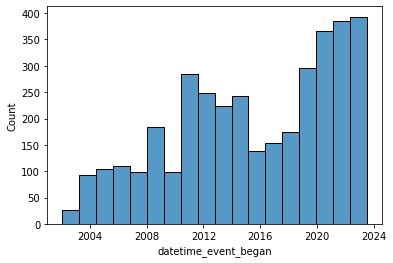

In [132]:
sns.histplot(data=disturbances, x='datetime_event_began')
plt.show()

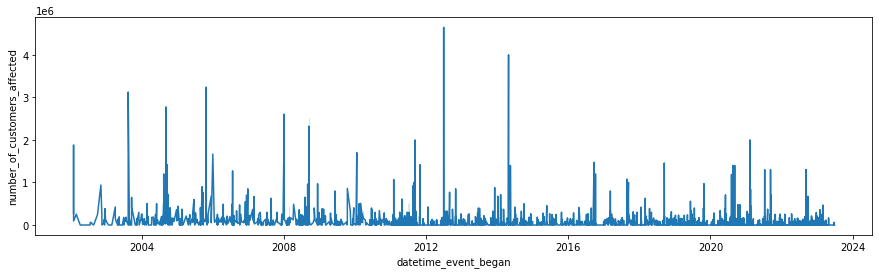

In [269]:
plt.figure(figsize=(15, 4))
sns.lineplot(data=disturbances, x='datetime_event_began', y="number_of_customers_affected")
plt.show()

## Step 4 Conclusion and next steps

In [ ]:
# NOTE: I have lost some of the merged cell data from the area column of 2002 sheet, to revisit and look at data dictionary for better understanding
# NOTE: Have i deleted some important data when cleaning my rows that are not datetime data? to review.
# NOTE: when converting the datetime columns to datetime datatypes I set utc=True. This will need to be reviewed.